# Optimal network reinforcement solution for distributed generation rise.

Description of the project

In [2]:
import pandapower as pp
import pandapower.networks as pn
import pandapower.topology
import pandapower.plotting
import pandapower.converter
import pandapower.estimation
from pandapower.plotting import cmap_continuous, cmap_discrete, create_bus_collection, create_line_collection, draw_collections,create_trafo_collection
import pandas
import numpy as np

### Functions

In [62]:
#Initialisation
def Init(case,pmw_gen=5):
    net = case
    #Calculate the length of the lines
    for i,length in enumerate(net.line['length_km']):
        x1,y1 = float(net.bus_geodata['x'][net.line['from_bus'][i]]), float(net.bus_geodata['y'][net.line['from_bus'][i]])
        x2,y2 = float(net.bus_geodata['x'][net.line['to_bus'][i]]), float(net.bus_geodata['y'][net.line['to_bus'][i]])
        net.line['length_km'][i] = np.sqrt((x1-x2)**2+(y1-y2)**2)

    #Creating the generator
    x_gen, y_gen = -3.534,1.813 #Determine on QGis
    pp.create_bus(net,geodata=(x_gen,y_gen),vn_kv=115,max_vm_pu=1.1,min_vm_pu=0.9,name=200,zone=1) #Change the value of vn_kv?
    #Create generator at the created node (200)
    pp.create_gen(net, 200,p_mw=pmw_gen,max_p_mw=100,min_p_mw=5) #Change the p_mw, max and min value?
    return net

#Technical violation functions
    #Visual plot
def Plot(net): #Plot map with in red the problematic(s) line(s),node(s) or transformator(s)
    # plot network with color codes
    cmap_list_node = [((0,0.97), "orangered"), ((0.97,1.1), "blue"), ((1.1,2), "red")]
    cmap_n, norm_n = cmap_discrete(cmap_list_node)
    bc = create_bus_collection(net, size=0.2, cmap=cmap_n, norm=norm_n);
    
    cmap_list_line = [((0, 95), "green"),((95,100),"yellow"), ((100, 200), "red")]
    cmap_l, norm_l = cmap_discrete(cmap_list_line)
    lc = create_line_collection(net, cmap=cmap_l, norm=norm_l,use_bus_geodata=True)
    
    cmap_list_trafo = [((0, 95), "lightgreen"),((95,100),"gold"), ((100, 200), "tomato")]
    cmap_t, norm_t = cmap_discrete(cmap_list_trafo)
    tc = create_trafo_collection(net,size=0.08,cmap=cmap_t, norm=norm_t)
    
    draw_collections([bc,tc,lc])

    # check constraints violation - voltage - bus
def isVoltageViolation(net):
    vMin,vMax, Node = 0.9, 1.1, [] #Init
    for k,v in enumerate(net.res_bus['vm_pu']):
        if v>vMax or v<vMin: #if violation
            Node.append(k)  #save the bus index
    return Node

    # check constraints violation - current - line
def isCurrentViolation(net):
    iMax, Line = net.line['max_i_ka'], [] #Init
    for k, i in enumerate(net.res_line['i_ka']):
        if i>iMax[k]: #if violation
            Line.append(k) #save the line index
    return Line

    # check constraints violation - load - transformer
def isTransformerViolation(net):
    loadmax, Trafo = 100, []
    for k, t in enumerate(net.res_trafo['loading_percent']):
        if t>loadmax: #if violation
            Trafo.append(k) #save the trafo index
    return Trafo
    
    #Return boolean of "is there violation?" with the value of bus, line and transfo that the limiting factor.
def isThereViolation(net,plot=False): 
    if plot:
        Plot(net)
    N,L,T = isVoltageViolation(net),  isCurrentViolation(net),  isTransformerViolation(net)
    if N!=[] or L!=[] or T!=[]:
        return True, N, L , T
    return False, N, L, T

#Function of connexion

    #Connect the generator to the network at bus "node". plot the line
def ConnexionGen(net, node,p_mw=5, plot=True): 
    net.gen['p_mw'][37] = p_mw
    x_nod = float(net['bus_geodata']['x'][net['bus_geodata'].index==node])
    y_nod = float(net['bus_geodata']['y'][net['bus_geodata'].index==node])
    x_gen, y_gen = -3.534,1.813 #Determine on QGis
    len_con = np.sqrt((x_gen-x_nod)**2+(y_gen-y_nod)**2)
    pp.create_line(net,200,node,length_km=len_con,std_type="243-AL1/39-ST1A 20.0") #generator at bus 200
    pp.runpp(net)
    return isThereViolation(net,plot=plot)

    #return max power of the added generator for the given network organisation
def MaxPow(net, p_min = 0, p_max = 150,N=100): 
    i=0
    while i<N:
        p_mw = (p_min+p_max)/2
        net.gen['p_mw'][37] = p_mw
        pp.runpp(net)
        if not isThereViolation(net)[0]:
            p_min = p_mw
        else:
            p_max = p_mw
        i+=1
    if p_mw==p_max:
        print("Limit p_mw: change p_max/p_min")
    return net.gen['p_mw'][37]

 ### Initial network: Illinois200 case study with a generator to connect

This pandapower network includes the following parameter tables:
   - bus (201 elements)
   - load (108 elements)
   - sgen (11 elements)
   - gen (38 elements)
   - shunt (4 elements)
   - ext_grid (1 element)
   - line (179 elements)
   - trafo (66 elements)
   - poly_cost (49 elements)
   - bus_geodata (201 elements)
 and the following results tables:
   - res_bus (201 elements)
   - res_line (179 elements)
   - res_trafo (66 elements)
   - res_ext_grid (1 element)
   - res_load (108 elements)
   - res_sgen (11 elements)
   - res_shunt (4 elements)
   - res_gen (38 elements)


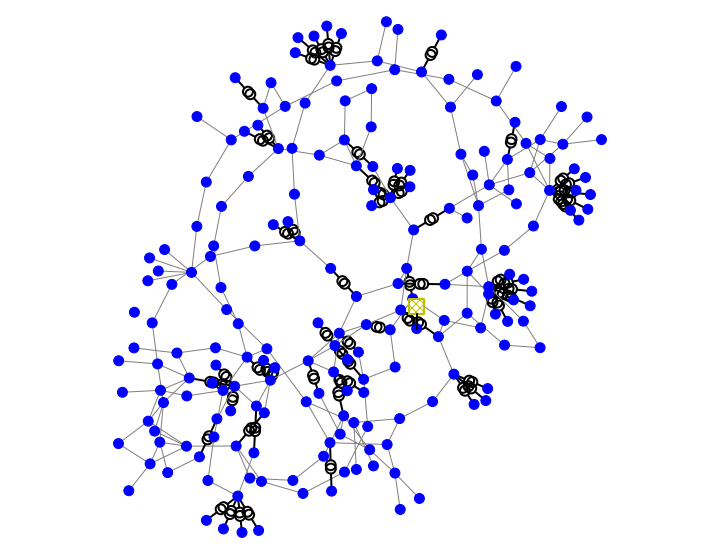

In [63]:
network = Init(pn.case_illinois200(),pmw_gen=5)
pp.runpp(network)
print(network)
#pandapower.to_excel(network, "AC_datas.xlsx")
pandapower.plotting.simple_plot(network);

#### Zoom in the generator with bus names
![BUSNUMBER](./GeoData/BusNumber.bmp)

128.1391998292803

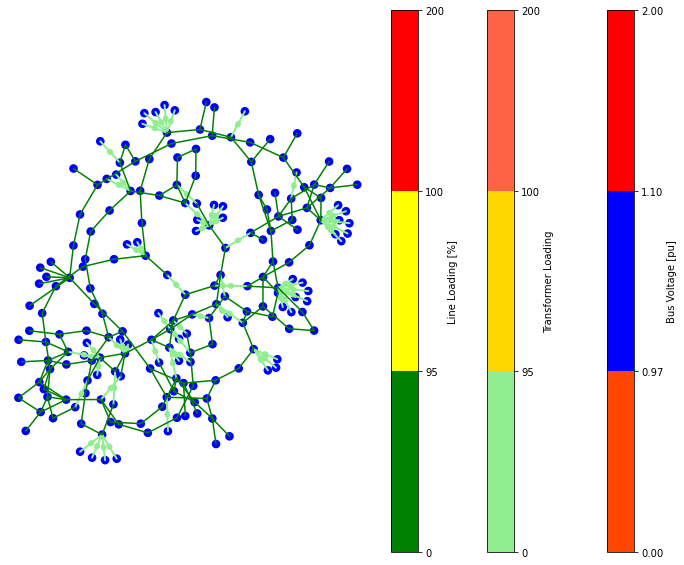

In [64]:
# Exemple withour problem
network = Init(pn.case_illinois200())
pp.runpp(network)
ConnexionGen(network,16,p_mw = 110)
MaxPow(network)

Limit p_mw: change p_max/p_min


1.1832913578315177e-28

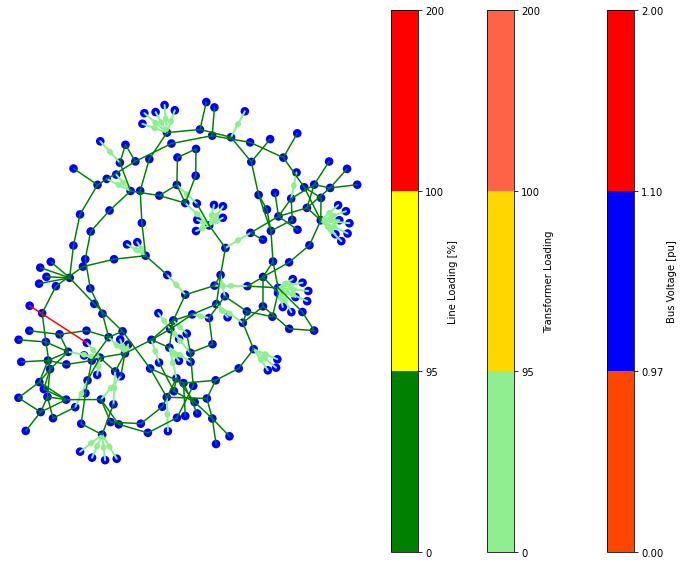

In [67]:
#Example with problem
network = Init(pn.case_illinois200())
pp.runpp(network)
ConnexionGen(network,125,p_mw=5)
MaxPow(network)